# Prototyping

First we need to prototype our solution.  First we begin with our inputs and outputs

![](Plots/Sol6-1.png)

Then add the logical steps we will need:

![](Plots/Sol6-2.png)

Now we must decide what candidate routines we will use for each section:

![](Plots/Sol6-3.png)

Of these only the 2nd and 3rd look non-trivial so we need to test which method will work best:

![](Plots/Sol6-4.png)

# Testing 
So lets do some tests to see what smoothing rouine works best for us to avoid multiple peaks due to noise: 

/Users/jamesfergusson/miniconda3/envs/HPC_course/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


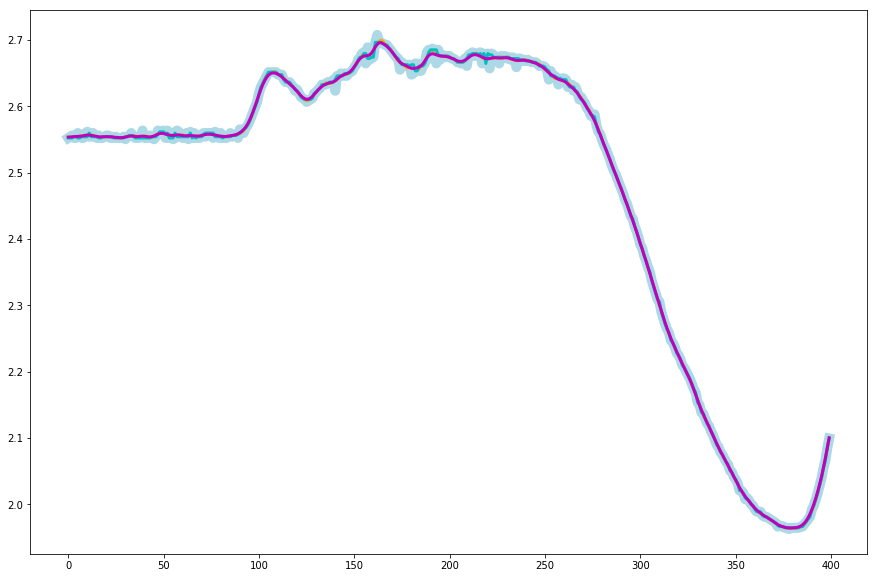

In [36]:
# Test smoothing
import numpy as np
import scipy.signal as scs
import scipy.ndimage.filters as scf 

import matplotlib.pyplot as plt

D1 = np.loadtxt('Data/Period2.txt')
S1 = scs.savgol_filter(D1, 11, 2)
S2 = scs.medfilt(D1, 5)
S3 = scf.gaussian_filter1d(D1,2)

fig = plt.figure(figsize=(15,10))
ax = plt.axes()

ax.plot(D1[200:600],linewidth=10,color='lightblue')
ax.plot(S1[200:600],linewidth=3,color='orange')
ax.plot(S2[200:600],linewidth=3,color='c')
ax.plot(S3[200:600],linewidth=3,color='m')

From playing with this it looks like both Savitzky-Golay filtering and Gaussian smoothing both work pretty well.  We can easily edit the scale when we test out peakfinders.

/Users/jamesfergusson/miniconda3/envs/HPC_course/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/jamesfergusson/miniconda3/envs/HPC_course/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


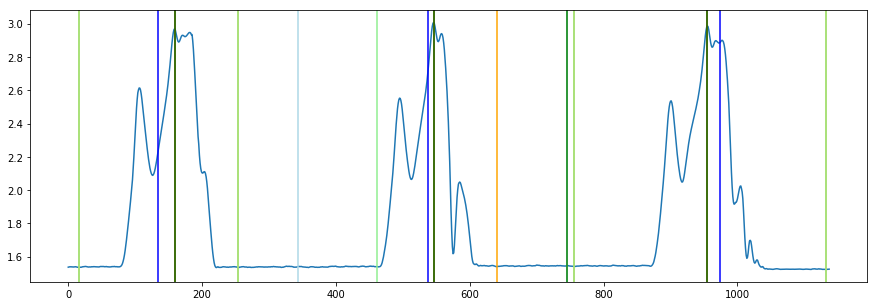

[159 546 955]
[134 537 974]
[159 546 746 955]
[  16  254  640  756 1132]
[344 746]
[  16  254  461  756 1132]


In [26]:
# Test peak finders
import numpy as np
import scipy.signal as scs
import scipy.ndimage.filters as scf 

import matplotlib.pyplot as plt

D1 = np.loadtxt('Data/Period4.txt')
S1 = scs.savgol_filter(D1, 11, 3)
S2 = scf.gaussian_filter1d(D1,2)

maxs1 = scs.argrelextrema(S2,np.greater,order=100)[0]
mins1 = scs.argrelextrema(S2,np.less,order=100)[0]

maxs2 = scs.find_peaks_cwt(S2,np.arange(90,110))
mins2 = scs.find_peaks_cwt(-S2,np.arange(90,110))

maxs3 = scs.find_peaks(S2,distance=200)[0]
mins3 = scs.find_peaks(-S2,distance=200)[0]

fig = plt.figure(figsize=(15,5))
ax = plt.axes()

ax.plot(S1)
for i in maxs1:
    ax.axvline(x=i,color='r')
for i in mins1:
    ax.axvline(x=i,color='orange')
for i in maxs2:
    ax.axvline(x=i,color='b')
for i in mins2:
    ax.axvline(x=i,color='lightblue')
for i in maxs3:
    ax.axvline(x=i,color='g')
for i in mins3:
    ax.axvline(x=i,color='lightgreen')
    
plt.show()

print(maxs1)
print(maxs2)
print(maxs3)

print(mins1)
print(mins2)
print(mins3)

So the wavelet transform method misses the peak instead catching the 'centre' of the pulse.  Both the other two mostly agree but `find_peaks` has one false positive maximum but misses two minimums, one at each end. Both work with our smoothing so that's fine.  However this raises the issue that we had to give the routines a 'scale' to work with, here we decided that the peaks we roughly 200 wide by eye but this need to be automated.  Our new plan looks like this:

![](Plots/Sol6-5.png)

In [31]:
# Find scale
import numpy as np
import scipy.signal as scs
import scipy.ndimage.filters as scf 
from scipy.fftpack import fft

# scales done by eye
scale = [285,158,227,387]

for i in range(1,5):
    file = 'Data/Period{}.txt'.format(i)
    D1 = np.loadtxt(file)
    S1 = scs.savgol_filter(D1, 11, 3)
    S2 = scf.gaussian_filter1d(D1,2)
    size = len(S1)

# Test fft
    F1 = fft(S1)
    maxfreq = np.argmax(np.abs(F1[1:30]))+1
    npts = np.shape(S1)[0]
    period = int(npts//maxfreq)

# Test autocorrelation
    result = np.correlate(S1-np.mean(S1), S1-np.mean(S1), mode='full')
# Not interested in results less than 30 and need to weight by number of points overlaping
    test = result[30:size//2]*np.arange(size//2,30,-1)
    index = np.argmax(test)
    
    print(scale[i-1],period,index+30)
    

285 263 261
158 152 287
227 256 403
387 379 341


/Users/jamesfergusson/miniconda3/envs/HPC_course/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


So it seems that `fft` performs better that autocorrelation.  

# Code
Now we can write our code (with documentation):

/Users/jamesfergusson/miniconda3/envs/HPC_course/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Max Type
Min Type
Min Type
Max Type


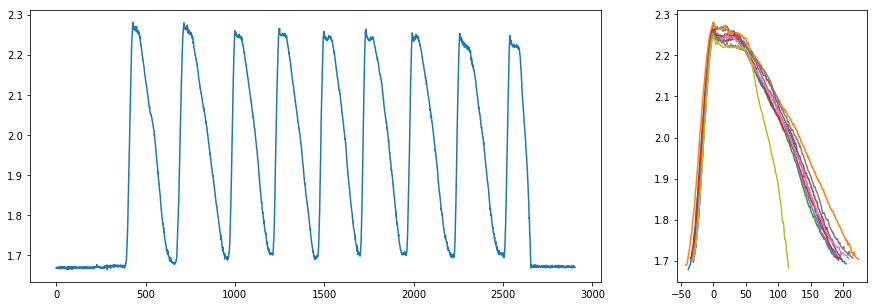

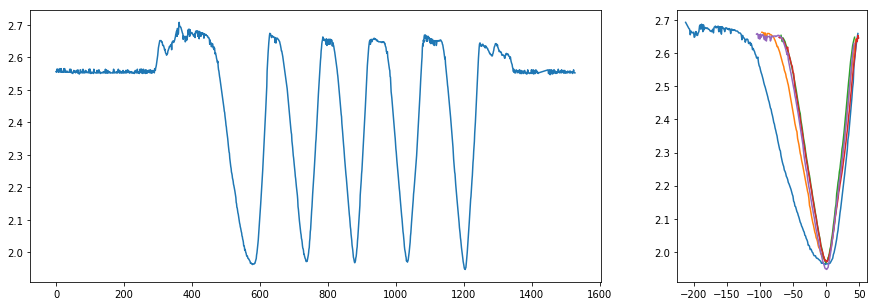

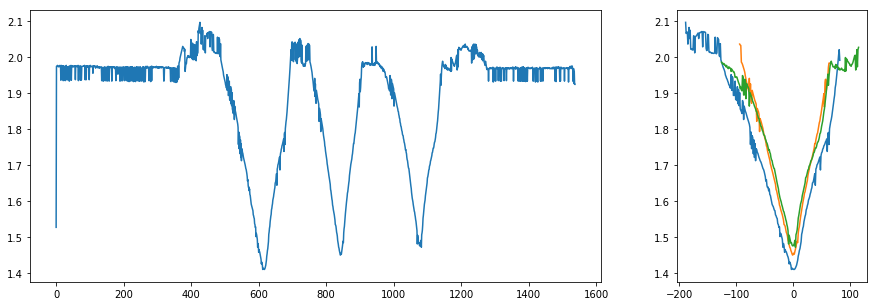

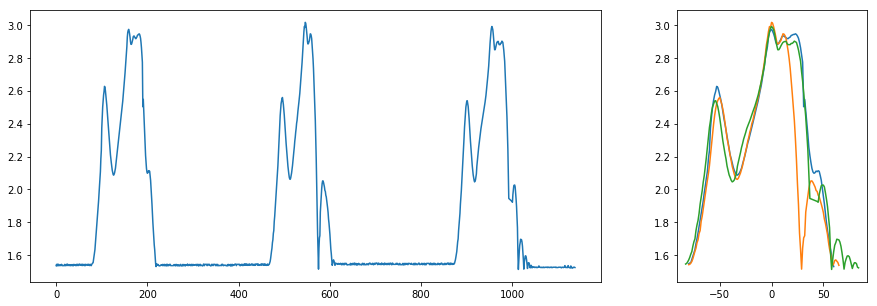

In [35]:
# Code to find repeating patterns in 1D data
# 
# Structure is:
#     1. Smooth
#     2. Find Scale
#     3. Find Extrema
#     4. Remove false positives
#     5. Group into events
#     6. Clean events
#     7. Plot events together

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from scipy.fftpack import fft
from scipy.fftpack import ifft
import scipy.signal as scs

# loop over files
for n in range(1,5):
    file = 'Data/Period{}.txt'.format(n)
    # load data and get size 
    D1 = np.loadtxt(file)
    size = np.shape(D1)[0]

    # ***** Smooth *****
    # Smooth with Savitzky-Golay filter
    # (least squares fit for polynomial)
    # Using poly order 3 and window size 11
    S1 = scs.savgol_filter(D1, 11, 3)

    # ***** Find scale*****
    # Find scale for patterns using fft
    F1 = fft(S1)
    # Only pick low frequencies
    maxfreq = np.argmax(np.abs(F1[1:30]))+1
    npts = np.shape(S1)[0]
    # set length to search over for max an min
    # too large and we lose reps
    # too small and we get multiple false max and min
    # argrelextrema takes half width so needs to be less than 
    # 0.5*npts/maxfreq
    period = int(0.35*npts/maxfreq)

    # ***** Find Extrema *****
    maxs = scs.argrelextrema(S1,np.greater,order=period)[0]
    mins = scs.argrelextrema(S1,np.less,order=period)[0]

    # get mid point between max and min
    mmax = np.max(S1[maxs])
    mmin = np.min(S1[mins])
    mid = (mmax+mmin)*0.5

    # remove max or mins on wrong side of midpoint
    maxs = maxs[S1[maxs]>mid]
    mins = mins[S1[mins]<mid]

    # Find median max and mins
    medmax = np.median(S1[maxs])
    medmin = np.median(S1[mins])

    # Only accept max and mins larger or smaller than 0.1 of median
    maxs = maxs[S1[maxs]>medmax-0.1]
    mins = mins[S1[mins]<medmin+0.1]

    # ***** Group into Events *****
    # First determine if the peaks are mins or maxs
    # then either find the min before and after for each max
    # or find the max before and after for each min 
    if (mins[0]<maxs[0] and mins[-1]>maxs[-1]):
        print('Max Type')
        reps = np.zeros((np.shape(maxs)[0],3), dtype='float')
        for i, mx in enumerate(maxs):
            reps[i,1] = mx
            for j, mn in enumerate(mins):
                if mn>mx:
                    break
            reps[i,0] = mins[j-1]
            reps[i,2] = mn
    elif (maxs[0]<mins[0] and maxs[-1]>mins[-1]):
        print('Min Type')
        reps = np.zeros((np.shape(mins)[0],3), dtype='float')
        for i, mn in enumerate(mins):
            reps[i,1] = mn
            for j, mx in enumerate(maxs):
                if mx>mn:
                    break
            reps[i,0] = maxs[j-1]
            reps[i,2] = mx
    else:
        print('Odd problem')

    # Trim ends of events by:
    # winding forward until change by 0.1
    # then winding back until changes by 0.09
    # for each end
    for index, rep in enumerate(reps):
        i1 = int(rep[0])
        x1 = S1[i1]
        while abs(S1[i1]-x1)<0.1:
            i1 += 1
        while abs(S1[i1]-x1)>0.01:
            i1 -= 1
        reps[index,0] = i1

        i1 = int(rep[2])
        x1 = S1[i1]
        while abs(S1[i1]-x1)<0.1:
            i1 -= 1
        while abs(S1[i1]-x1)>0.01:
            i1 += 1
        reps[index,2] = i1

    # ***** Plot *****
    fig = plt.figure(figsize=(15,5))
    grid = gs.GridSpec(1,2,width_ratios=[3,1])
    ax1 = plt.subplot(grid[0,0])
    ax2 = plt.subplot(grid[0,1])   

    ax1.plot(D1)

    for i in range(np.shape(reps)[0]):
        ax2.plot(np.arange(reps[i,0],reps[i,2])-reps[i,1],D1[int(reps[i,0]):int(reps[i,2])])

Here is the actual prototyping I did for this example:

![](Plots/Sol6-draft.png)